## Solving a inverse heat equation

We solve an inverse 2D heat equation and find the heat diffusion coefficent $D$.

In [9]:
import urllib
print('TorchPhysics Tutorial')
url = 'https://torchphysics.readthedocs.io/en/latest/tutorial/tutorial_start.html'
print(url)

TorchPhysics Tutorial
https://torchphysics.readthedocs.io/en/latest/tutorial/tutorial_start.html


In [10]:
import torch
import torchphysics as tp
import math

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # select GPUs to use

In [11]:
from IPython.display import display, Math, Latex
print(r'Underlying PDE for inverse problem')
display(Math(r'u_t(t,x) + D \cdot \Delta u(t,x) = 0\,, \quad x\in \Omega=[0,h]\times[0,w]\,, \
             \quad t \in [0,T]'))
print('Measurment data are given, the heat coefficient D should be calculated')

print('Feber report with basics and examples:')
url = 'https://inside-hosted-apps.bosch.com/FEBER/FeberApp/Pages/AMFile.aspx?Guid=4f66940a_de51_4187_9c26_90c21537b73f'
print(url)

Underlying PDE for inverse problem


<IPython.core.display.Math object>

Measurment data are given, the heat coefficient D should be calculated
Feber report with basics and examples:
https://inside-hosted-apps.bosch.com/FEBER/FeberApp/Pages/AMFile.aspx?Guid=4f66940a_de51_4187_9c26_90c21537b73f


Like always we first define the spaces. Even if we want to find the value of $D$ we still define a space for this coefficent.

In [12]:
X = tp.spaces.R2('x')
T = tp.spaces.R1('t')
D = tp.spaces.R1('D') # one dimensional parameter

U = tp.spaces.R1('u')

Next are the domains for space and time

In [13]:
w, h = 10, 10
t_0, t_end = 0, 10
temp_hot = 10

domain_x = tp.domains.Parallelogram(X, [0, 0], [w, 0], [0, h])
domain_t = tp.domains.Interval(T, t_0, t_end)

Now we construct the neural network like always, since we will not only find $D$ but also create a *interpolation* of the given data. 

For the parameter that we want to find, we use the class *Parameter*, which gets an inital guess and a spaces as an input. This parameter then has to be passed to the conditions, to be trained. 

In [14]:
# D NOT input of the model:
model = tp.models.FCN(input_space=X*T, output_space=U, hidden=(30,30,30))

param_D = tp.models.Parameter(init=0.0, space=D)

We need some data to use in the inverse problem, for this we create a solution with a FDM scheme.

In [15]:
import sys
sys.path.append('../..')

from fdm_heat_equation import FDM, transform_to_points

def inital_value(x):
    return temp_hot*torch.sin(math.pi/w*x[:,0])*torch.sin(math.pi/h*x[:,1])

final_D = 1.0 # the D value we want to find 
fdm_domain, fdm_time_domains, fdm_solution = FDM([0, w, 0, h], 2*[0.5], [t_0,t_end], [final_D], inital_value)
# transform to correct format for our use:
fdm_inp, fdm_out = transform_to_points(fdm_domain, fdm_time_domains, fdm_solution, [final_D], False)

Now we have around 40.000 data points. But we only want to use a few, so we use random.choice to pick here Npoints=500,2000,5000 points

In [24]:
import numpy as np
Npoints = 250
index = np.random.choice(len(fdm_inp), Npoints, replace=False) 
fdm_inp = fdm_inp[index, ]
fdm_out = fdm_out[index, ]

This data we use now to create a data condition that will train the network:

In [25]:
data_loader = tp.utils.PointsDataLoader((fdm_inp, fdm_out), batch_size = Npoints) # 500, 1000, 5000
data_condition = tp.conditions.DataCondition(module=model,
                                             dataloader=data_loader,
                                             norm=2, 
                                             use_full_dataset=True) 

To learn the parameter we have to use the PDE itself. Therefore we will create, just like in the forward problem, a condition for the PDE. For this condition we have to pass in the parameter $D$ we created.

In [26]:
# with static sampling points
# inner_sampler = tp.samplers.RandomUniformSampler(domain_x*domain_t, n_points=Npoints).make_static() 
#
# with dynamics sampling points
inner_sampler = tp.samplers.RandomUniformSampler(domain_x*domain_t, n_points = Npoints) # 500,1000, 5000

def heat_residual(u, x, t, D):
    return D*tp.utils.laplacian(u, x) - tp.utils.grad(u, t)

pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=heat_residual,
                                            name='pde_condition', 
                                            parameter=param_D) # here pass in the param

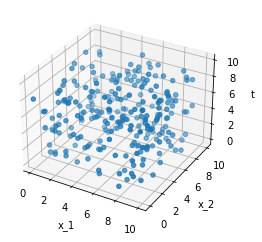

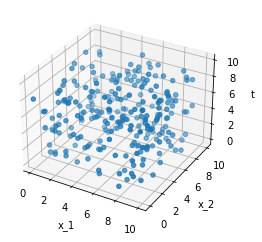

In [27]:
tp.utils.scatter(X*T, inner_sampler)

This is all we have to do, to define the inverse problem. Now we can already start the training like always and the parameter $D$ will be learned too. 

In [28]:
opt_setting = tp.solver.OptimizerSetting(torch.optim.AdamW, lr=1e-2)
solver = tp.solver.Solver([pde_condition, data_condition], optimizer_setting = opt_setting)

import pytorch_lightning as pl

trainer = pl.Trainer(gpus=0,
                     max_steps=1000,
                     #logger=False, #False = tensorboard logs off
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 2.0 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\python\torchphysics\_venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\python\torchphysics\_venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Finally we can have a look on the value of D. Which is pretty close to $D=1.0$, that we used in FDM to create the data.

In [29]:
param_D

Parameter:
{'D': tensor([[0.9937]], grad_fn=<AliasBackward>)}

And the neural network learned the solution $u(x, t)$:

C:\Users\krd2rng\AppData\Local\Temp/ipykernel_19724/153666424.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
C:\Users\krd2rng\AppData\Local\Temp/ipykernel_19724/153666424.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dvi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('IHDE.png', dvi=600)


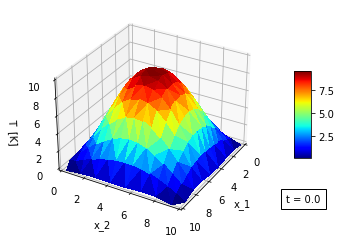

In [30]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=domain_x, n_points=200,
                                       data_for_other_variables={'t': 0.0 })
fig = tp.utils.plot(model, lambda u : u, plot_sampler)
import matplotlib.pyplot as plt

ax = fig.gca(projection='3d')
ax.set(xlim=(0, w), ylim=(0, h), zlim = (0,temp_hot))
ax.set_zlabel('T  [K]')
plt.savefig('IHDE.png', dvi=600)

tensor(1.3921, grad_fn=<UnbindBackward>)
tensor(-0.3475, grad_fn=<UnbindBackward>)


C:\Users\krd2rng\AppData\Local\Temp/ipykernel_19724/3860495763.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dvi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('HDE_static_Tmaxmin.png', dvi = 600)


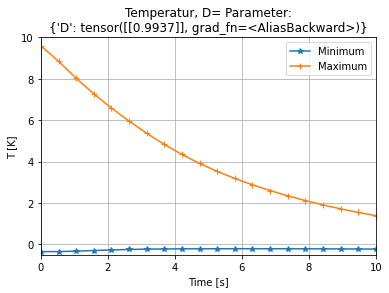

In [31]:
grid_sampler = tp.samplers.GridSampler(domain_x, n_points=128*128)
grid_points = grid_sampler.sample_points()

time_steps = 20
time_points = torch.linspace(0, t_end, time_steps)
min_max_tensor = torch.zeros((time_steps, 2))

for i in range(time_steps):
    time_tensor = time_points[i] * torch.ones((len(grid_points), 1))
    eval_points = grid_points.join(tp.spaces.Points.from_coordinates({'t': time_tensor}))
    model_out = model(eval_points)
    min_max_tensor[i, 0] = torch.min(model_out)
    min_max_tensor[i, 1] = torch.max(model_out)

import matplotlib.pyplot as plt
plt.plot(time_points, min_max_tensor[:, 0].detach().numpy(), marker='*')
plt.plot(time_points, min_max_tensor[:, 1].detach().numpy(), marker='+')
plt.legend(['Minimum', 'Maximum'])
plt.title('Temperatur, D= ' + str(param_D))
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('T [K]')
plt.axis([0,t_end,-0.5,temp_hot])
plt.savefig('HDE_static_Tmaxmin.png', dvi = 600)

print(min(min_max_tensor[:,1]))
print(min(min_max_tensor[:,0]))
